<br />

<div style="text-align: center;">
<font size="7">Training Custom Machine learning Models</font>
<br /> 
<br /> 
<font size="5">PyTorch Cifar10</font>
    
</div>
<br />


<div style="text-align: right;">
<font size="4">2020/11/11</font>
<br />
<font size="4">Ryutaro Hashimoto</font>
</div>

___

# Summary
- We will use a container image of a pre-built-in SageMaker execution environment and the source code of our own model.
- In this case, we use the Pytorch container image.
- Download the Cifar10 dataset and implement the CNN.


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Pre-requisites" data-toc-modified-id="Pre-requisites-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Pre-requisites</a></span></li><li><span><a href="#Prepare-Cifar10-dataset" data-toc-modified-id="Prepare-Cifar10-dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prepare Cifar10 dataset</a></span><ul class="toc-item"><li><span><a href="#2.1.-Download-the-Cifar10-dataset" data-toc-modified-id="2.1.-Download-the-Cifar10-dataset-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>2.1. Download the Cifar10 dataset</a></span></li><li><span><a href="#Data-Preview" data-toc-modified-id="Data-Preview-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Data Preview</a></span></li><li><span><a href="#Upload-the-data" data-toc-modified-id="Upload-the-data-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Upload the data</a></span></li></ul></li><li><span><a href="#Writing-Model-Scripts" data-toc-modified-id="Writing-Model-Scripts-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Writing Model Scripts</a></span></li><li><span><a href="#Start-a-learning-job" data-toc-modified-id="Start-a-learning-job-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Start a learning job</a></span></li><li><span><a href="#Deploy-trained-models-and-create-endpoints-for-prediction" data-toc-modified-id="Deploy-trained-models-and-create-endpoints-for-prediction-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Deploy trained models and create endpoints for prediction</a></span></li><li><span><a href="#Invoking-the-endpoint" data-toc-modified-id="Invoking-the-endpoint-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Invoking the endpoint</a></span></li><li><span><a href="#Clean-up" data-toc-modified-id="Clean-up-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Clean-up</a></span></li></ul></div>

## Pre-requisites

Set the bucket, IAM role, and instance type to be used

In [1]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = 'sagemaker-tutorial'
prefix = 'sagemaker/DEMO-pytorch-cnn-cifar10'

role_ARN = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxx'    # ← your iam role ARN

import os
import subprocess

instance_type = 'ml.p2.xlarge'

print("Instance type = " + instance_type)

Instance type = ml.p2.xlarge


## Prepare Cifar10 dataset

### 2.1. Download the Cifar10 dataset

In [2]:
from utils_cifar import get_train_data_loader, get_test_data_loader, imshow, classes

trainloader = get_train_data_loader()
testloader = get_test_data_loader()

Files already downloaded and verified
Files already downloaded and verified


### Data Preview

      cat      ship     horse      deer


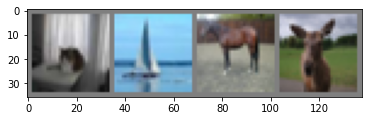

In [3]:
import numpy as np
import torchvision, torch

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%9s' % classes[labels[j]] for j in range(4)))

### Upload the data
We use the ```sagemaker.Session.upload_data``` function to upload our datasets to an S3 location. The return value inputs identifies the location -- we will use this later when we start the training job.

In [4]:
inputs = sagemaker_session.upload_data(path='data', bucket=bucket, key_prefix='data/cifar10')

## Writing Model Scripts
Here is the full code for the network model:

In [5]:
!pygmentize source/cifar10.py

import argparse
import logging
import sagemaker_containers

import os

import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision
import torchvision.models
import torchvision.transforms as transforms
import torch.nn.functional as F

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py#L118
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.r

## Start a learning job

In [6]:
from sagemaker.pytorch import PyTorch

inputs = '<S3path>'

cifar10_estimator = PyTorch(entry_point='source/cifar10.py',
                            role=role_ARN,
                            framework_version='1.4',
                            py_version='py3',
                            instance_count=1,
                            instance_type='ml.p2.xlarge')

In [7]:
cifar10_estimator.fit(inputs)

2021-02-09 04:39:46 Starting - Starting the training job...
2021-02-09 04:40:10 Starting - Launching requested ML instancesProfilerReport-1612845585: InProgress
......
2021-02-09 04:41:11 Starting - Preparing the instances for training.........
2021-02-09 04:42:52 Downloading - Downloading input data...
2021-02-09 04:43:32 Training - Downloading the training image..........bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-02-09 04:45:17,503 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-02-09 04:45:17,529 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-02-09 04:45:18,952 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-02-09 04:45:19,315 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
2021-02-09 04:45:19,315 sagemaker-containers INFO    

## Deploy trained models and create endpoints for prediction

In [8]:
from sagemaker.pytorch import PyTorchModel

cifar10_predictor = cifar10_estimator.deploy(initial_instance_count=1,
                                             instance_type='ml.t2.medium')

-------------------!

## Invoking the endpoint

GroundTruth:   cat ship ship plane
Predicted:   cat ship ship ship


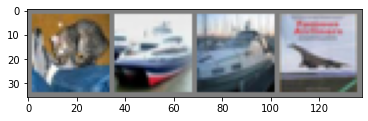

In [9]:
# get some test images
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%4s' % classes[labels[j]] for j in range(4)))

outputs = cifar10_predictor.predict(images.numpy())

_, predicted = torch.max(torch.from_numpy(np.array(outputs)), 1)

print('Predicted: ', ' '.join('%4s' % classes[predicted[j]]
                              for j in range(4)))

## Clean-up

Deleting the local endpoint when you're finished is important since you can only run one local endpoint at a time.

In [10]:
cifar10_predictor.delete_endpoint()

In [11]:
# End of File